In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from windIO.yaml import load_yaml 
from matplotlib.ticker import ScalarFormatter
from wifa.wayve_api import ci_fitting
from pathlib import Path
from scipy.spatial import ConvexHull

In [2]:
def update_heights(case,updated_heights):
    """.
    Interpolates the reference physical inputs to a new set of heights and saves the updated dataset.
    """
    meta_file=f"EDF_datasets/{case}/meta.yaml"
    meta=load_yaml(Path(meta_file))
    reference_physical_inputs = xr.load_dataset(f"EDF_datasets/{case}/{meta['ref_resource']}")
    updated_inputs=reference_physical_inputs.interp(height=updated_heights,method="linear",kwargs={"fill_value": "extrapolate"})
    updated_inputs.to_netcdf(f"EDF_datasets/{case}/updated_physical_inputs.nc")
    
    return updated_inputs

In [3]:
def recalculate_params(case):
    """
    Recalculate parameters from vertical profiles .

    - Loads the dataset
    - Recalculates:
        - Turbulence intensity from TKE and wind speed
        - ABL height, lapse rate, capping inversion strength/thickness using ci_fitting function in WAYVE API
    - Writes the updated dataset back to the same NetCDF file
    """

    # Load dataset and create copy
    reference_physical_inputs = xr.load_dataset(f"EDF_datasets/{case}/updated_physical_inputs.nc")
    ref_inputs_modified = reference_physical_inputs.copy()

    # Update TI
    ref_inputs_modified["turbulence_intensity"] = (
        np.sqrt((2 / 3) * reference_physical_inputs["k"]) / reference_physical_inputs["wind_speed"]
    )

    # Update inversion layer properties using ci_fitting
    def extract_ci_outputs(zs, ths, lmo, blh):
        inv_bottom, H, inv_top, th0, dth, dthdz = ci_fitting(
            zs=zs, ths=ths + 273, l_mo=lmo, blh=blh
        )
        return H, dthdz, dth, inv_top - inv_bottom

    H, dthdz, dth, inv_thickness = xr.apply_ufunc(
        extract_ci_outputs,
        reference_physical_inputs["height"],
        reference_physical_inputs["potential_temperature"],
        reference_physical_inputs["LMO"],
        reference_physical_inputs["ABL_height"],
        input_core_dims=[["height"], ["height"], [], []],
        output_core_dims=[[], [], [], []],
        vectorize=True,
        dask="allowed",
        output_dtypes=[float, float, float, float],
    )

    # Assign updated values to new dataset and overwrite updated_physical_inputs dataset
    ref_inputs_modified["ABL_height"] = H
    ref_inputs_modified["lapse_rate"] = dthdz
    ref_inputs_modified["capping_inversion_strength"] = dth
    ref_inputs_modified["capping_inversion_thickness"] = inv_thickness

    ref_inputs_modified.to_netcdf(f"EDF_datasets/{case}/updated_physical_inputs.nc")

In [4]:
def compare_physical_inputs(case_name: str, TI_height_idx: int, base_dir="EDF_datasets", updated_file="updated_physical_inputs.nc"):
    """
    Compare original and modified physical inputs for a given case.
    
    Parameters:
    - case_name: name of the case (used for path construction)
    - TI_height_idx: index of height at which to extract TI
    - base_dir: base directory containing cases
    - updated_file: name of the updated netcdf file (relative to case directory)
    """
    meta_file = f"{base_dir}/{case_name}/meta.yaml"
    meta = load_yaml(Path(meta_file))
    
    # Load datasets
    original_path = f"{base_dir}/{case_name}/{meta['ref_resource']}"
    updated_path = f"{base_dir}/{case_name}/{updated_file}"
    
    ds_orig = xr.load_dataset(original_path)
    ds_mod = xr.load_dataset(updated_path)
    
    fig, axs = plt.subplots(5, 1, figsize=(8, 15), sharex=True)

    # Capping inversion strength [K]
    axs[0].plot(ds_orig.capping_inversion_strength.values, label="Old", linestyle="--")
    axs[0].plot(ds_mod.capping_inversion_strength.values, label="New")
    axs[0].set_title("Capping Inversion Strength")
    axs[0].set_ylabel(r"$\Delta \theta$ [K]")
    axs[0].legend()

    # Capping inversion thickness [m]
    axs[1].plot(ds_orig.capping_inversion_thickness.values, label="Old", linestyle="--")
    axs[1].plot(ds_mod.capping_inversion_thickness.values, label="New")
    axs[1].set_title("Capping Inversion Thickness")
    axs[1].set_ylabel("Thickness [m]")
    axs[1].legend()

    # ABL Height [m]
    axs[2].plot(ds_orig.ABL_height.values, label="Old", linestyle="--")
    axs[2].plot(ds_mod.ABL_height.values, label="New")
    axs[2].set_title("ABL Height")
    axs[2].set_ylabel("Height [m]")
    axs[2].legend()

    # Lapse Rate [K/m]
    axs[3].plot(ds_orig.lapse_rate.values, label="Old", linestyle="--")
    axs[3].plot(ds_mod.lapse_rate.values, label="New")
    axs[3].set_title("Lapse Rate")
    axs[3].set_ylabel(r"$\partial \theta / \partial z$ [K/m]")
    axs[3].legend()

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  # scientific notation outside range 10^-2 to 10^2
    axs[3].yaxis.set_major_formatter(formatter)

    # Turbulence Intensity (unitless)
    axs[4].plot(ds_orig.turbulence_intensity.values[:, TI_height_idx], label=f"Old (height idx {TI_height_idx})", linestyle="--")
    axs[4].plot(ds_mod.turbulence_intensity.values[:, TI_height_idx], label=f"New (height idx {TI_height_idx})")
    axs[4].set_title("Turbulence Intensity")
    axs[4].set_ylabel("TI [-]")
    axs[4].set_xlabel("Time index")
    axs[4].legend()

    plt.tight_layout()
    plt.show()

Listing the folders to navigate to

In [5]:
case_names=[
    "HR1",   
    "HR2",     
    "HR3",
    "NYSTED1",   
    "NYSTED2",
    "VirtWF_ABL_IEA10", 
    "VirtWF_ABL_IEA15_ali_DX5_DY5",   
    "VirtWF_ABL_IEA15_stag_DX5_DY5",    # this has 998 heights originally, interpolating later
    "VirtWF_ABL_IEA15_stag_DX5_DY7p5",  # this has 998 heights originally, interpolating later
    "VirtWF_ABL_IEA15_stag_DX7p5_DY5",  # this has 998 heights originally, interpolating later
    "VirtWF_ABL_IEA22"
]

Optionally looking at the netcdf file with input physical data for a specific case (commented below)

In [6]:
# # manually picking an index out of the case_names list above to look at physical input data for that case
# case_i=7

# # navigating to a file containing metadata required to run pywake api
# meta_file=f"EDF_datasets/{case_names[case_i]}/meta.yaml"
# meta=load_yaml(Path(meta_file)    )

# dat = load_yaml(Path(f"EDF_datasets/{case_names[case_i]}/{meta['system']}"))
# reference_physical_inputs = xr.load_dataset(f"EDF_datasets/{case_names[case_i]}/{meta['ref_resource']}")

# reference_physical_inputs

Interpolating height dimension on particular cases

In [7]:
# Initializing an updated dataset even for all cases, even those who do not have different heights

# Taking one of the cases as the reference to interpolate heights
meta_file=f"EDF_datasets/{case_names[0]}/meta.yaml"
meta=load_yaml(Path(meta_file))
dat = load_yaml(Path(f"EDF_datasets/{case_names[0]}/{meta['system']}"))
reference_physical_inputs = xr.load_dataset(f"EDF_datasets/{case_names[0]}/{meta['ref_resource']}")
new_heights=reference_physical_inputs.height

for case in case_names:
    update_heights(f"{case}",new_heights)

Recalculating physical parameters based on vertical profile  

In [8]:
# looping over all the cases and calling this function, which outputs that updated_physical_inputs file
for case in case_names:
    recalculate_params(case)

/home/ntion/miniconda3/envs/topfarm/lib/python3.11/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Plotting the changes in the physical inputs for a particular case

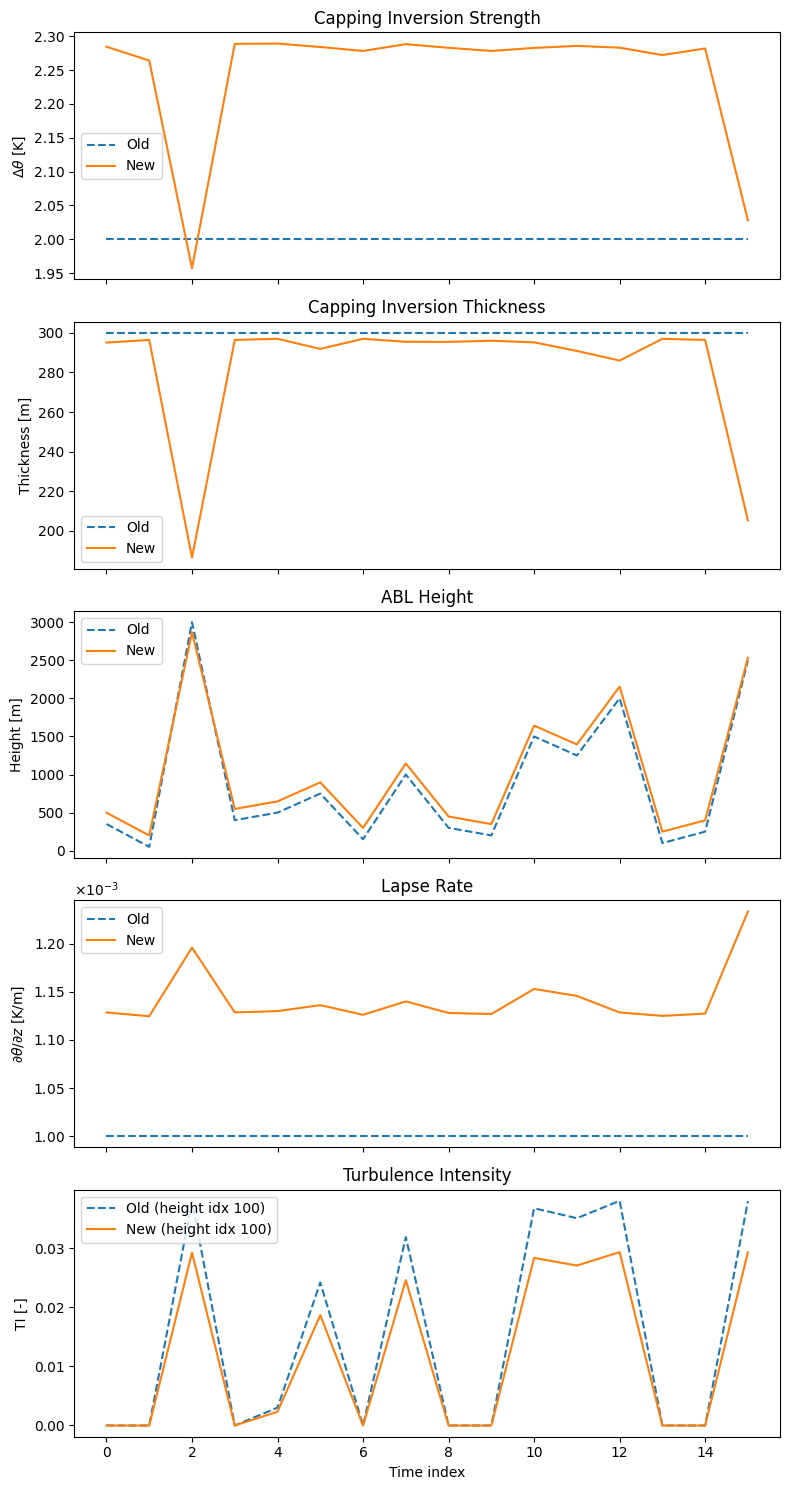

In [9]:
""". 
Reminder

case_names=[
    "HR1",   
    "HR2",     
    "HR3",
    "NYSTED1",   
    "NYSTED2",
    "VirtWF_ABL_IEA10", 
    "VirtWF_ABL_IEA15_ali_DX5_DY5",   
    "VirtWF_ABL_IEA15_stag_DX5_DY5",    # this has 998 heights originally, interpolating later
    "VirtWF_ABL_IEA15_stag_DX5_DY7p5",  # this has 998 heights originally, interpolating later
    "VirtWF_ABL_IEA15_stag_DX7p5_DY5",  # this has 998 heights originally, interpolating later
    "VirtWF_ABL_IEA22"
]

"""

# Need to choose a height to plot TI
compare_physical_inputs(case_name=case_names[5], TI_height_idx=100)